<a href="https://colab.research.google.com/github/candido05/ML_Projects/blob/main/OCR_CTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
def download_kaggle_dataset(dataset_url, output_path='.', kaggle_username=None, kaggle_key=None):
    """
    Baixa um dataset do Kaggle diretamente no Colab usando o link do repositório, sem interação do usuário.

    Parâmetros:
    dataset_url (str): URL do dataset no Kaggle (ex: https://www.kaggle.com/datasets/username/dataset-name)
    output_path (str): Caminho onde os arquivos serão salvos (padrão é o diretório atual)
    kaggle_username (str): Seu username do Kaggle
    kaggle_key (str): Sua chave API do Kaggle
    """
    !pip install -q kaggle

    try:
        dataset_path = '/'.join(dataset_url.split('/')[-2:]).split('?')[0]  # Remove parâmetros extras da URL
    except:
        raise ValueError("URL inválida. Use o formato: https://www.kaggle.com/datasets/username/dataset-name")

    import os
    if kaggle_username is None or kaggle_key is None:
        raise ValueError("Forneça seu kaggle_username e kaggle_key como argumentos.")

    os.makedirs('/root/.kaggle', exist_ok=True)
    with open('/root/.kaggle/kaggle.json', 'w') as f:
        f.write(f'{{"username":"{kaggle_username}","key":"{kaggle_key}"}}')
    !chmod 600 /root/.kaggle/kaggle.json

    os.makedirs(output_path, exist_ok=True)

    print(f"Baixando dataset: {dataset_path}")
    !kaggle datasets download -d {dataset_path} -p {output_path}

    import zipfile
    zip_files = [f for f in os.listdir(output_path) if f.endswith('.zip')]
    if zip_files:
        for zip_file in zip_files:
            with zipfile.ZipFile(f"{output_path}/{zip_file}", 'r') as zip_ref:
                zip_ref.extractall(output_path)
            print(f"Arquivo {zip_file} descompactado em {output_path}")
            os.remove(f"{output_path}/{zip_file}")
    else:
        print("Download concluído, mas nenhum arquivo .zip foi encontrado. Verifique se o dataset foi baixado corretamente.")

kaggle_username = ""
kaggle_key = ""
download_kaggle_dataset(
    "https://www.kaggle.com/datasets/ssarkar445/handwriting-recognitionocr",
    "/content/handwriting-recognitionocr",
    kaggle_username=kaggle_username,
    kaggle_key=kaggle_key
)

Baixando dataset: ssarkar445/handwriting-recognitionocr
Dataset URL: https://www.kaggle.com/datasets/ssarkar445/handwriting-recognitionocr
License(s): unknown
 99% 1.25G/1.26G [00:14<00:00, 143MB/s]
100% 1.26G/1.26G [00:14<00:00, 95.1MB/s]
Arquivo handwriting-recognitionocr.zip descompactado em /content/handwriting-recognitionocr


### Importações de bibliotecas

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output as cls

from glob import glob
from tqdm import tqdm
import tensorflow.data as tfd

import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras import layers

### Configurações iniciais

In [4]:
IMG_WIDTH = 200
IMG_HEIGHT = 50
IMAGE_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 16

EPOCHS = 50
MODEL_NAME = 'Handwritten-OCR'
CALLBACKS = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.ModelCheckpoint(filepath=MODEL_NAME + ".h5", save_best_only=True)
]
LEARNING_RATE = 1e-3

np.random.seed(2569)
tf.random.set_seed(2569)

In [5]:
train_csv_path = '/content/handwriting-recognitionocr/CSV/written_name_train.csv'
valid_csv_path = '/content/handwriting-recognitionocr/CSV/written_name_validation.csv'
test_csv_path = '/content/handwriting-recognitionocr/CSV/written_name_test.csv'

train_image_dir = '/content/handwriting-recognitionocr/train_v2/train'
valid_image_dir = '/content/handwriting-recognitionocr/validation_v2/validation'
test_image_dir = '/content/handwriting-recognitionocr/test_v2/test'

In [6]:
TRAIN_SIZE = BATCH_SIZE * 1000
VALID_SIZE = BATCH_SIZE * 500
TEST_SIZE  = BATCH_SIZE * 100

AUTOTUNE = tfd.AUTOTUNE

### Data Loading

In [7]:
train_csv = pd.read_csv(train_csv_path)[:TRAIN_SIZE]
valid_csv = pd.read_csv(valid_csv_path)[:VALID_SIZE]
test_csv = pd.read_csv(test_csv_path)[:TEST_SIZE]

In [8]:
train_csv.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [9]:
train_labels = [str(word) for word in train_csv['IDENTITY'].to_numpy()]
train_labels[:10]

['BALTHAZAR',
 'SIMON',
 'BENES',
 'LA LOVE',
 'DAPHNE',
 'LUCIE',
 'NASSIM',
 'ASSRAOUI',
 'LAVIAN',
 'MAEVA']

In [10]:
uniques_chars = set(char for word in train_labels for char in word)
n_classes = len(uniques_chars)

print(f"Número de classes únicas: {n_classes}")
print(f"Classes únicas: {uniques_chars}")

Número de classes únicas: 41
Classes únicas: {"'", 'p', 'R', 'J', 'C', 'u', 'F', 'y', 'M', 'e', 'U', 'E', 'I', 'r', 'G', '-', 'K', 'A', 'X', 'c', 'H', 'V', 'n', 's', 'Y', 'l', 'L', 'Q', 'O', 'D', 'N', 'T', 'W', 't', 'P', ' ', 'o', 'S', 'B', 'a', 'Z'}


In [11]:
MAX_LABEL_LENGTH = max(map(len, train_labels))
print(f"Maior tamanho de label: {MAX_LABEL_LENGTH}")

Maior tamanho de label: 24


In [12]:
train_csv['FILENAME'] = [train_image_dir + f"/{filename}" for filename in train_csv['FILENAME']]
valid_csv['FILENAME'] = [valid_image_dir + f"/{filename}" for filename in valid_csv['FILENAME']]
test_csv['FILENAME']  = [test_image_dir + f"/{filename}" for filename in test_csv['FILENAME']]

In [13]:
train_csv.head()

,FILENAME,IDENTITY
0,/content/handwriting-recognitionocr/train_v2/t...,BALTHAZAR
1,/content/handwriting-recognitionocr/train_v2/t...,SIMON
2,/content/handwriting-recognitionocr/train_v2/t...,BENES
3,/content/handwriting-recognitionocr/train_v2/t...,LA LOVE
4,/content/handwriting-recognitionocr/train_v2/t...,DAPHNE


### Pré-processamento dos labels

In [14]:
char_to_num = layers.StringLookup(
    vocabulary = list(uniques_chars),
    mask_token = None
)

num_to_char = layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    mask_token = None,
    invert = True
)

### Data Functions

In [15]:
def load_image(image_path: str):

  image = tf.io.read_file(image_path)
  decoded_image = tf.image.decode_jpeg(contents = image, channels = 1)
  cnvt_image = tf.image.convert_image_dtype(image = decoded_image, dtype = tf.float32)
  resized_image = tf.image.resize(images = cnvt_image, size=(IMG_HEIGHT, IMG_WIDTH))
  image = tf.transpose(resized_image, perm=[1, 0, 2])
  image = tf.cast(image, dtype = tf.float32)

  return image

In [16]:
def encode_single_sample(image_path: str, label: str):

    image = load_image(image_path)
    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')
    vecs = char_to_num(chars)
    pad_size = MAX_LABEL_LENGTH - tf.shape(vecs)[0]
    vecs = tf.pad(vecs, paddings = [[0, pad_size]], constant_values=n_classes+1)

    return {'image':image, 'label':vecs}

### Aplicação do pré-processamento

In [17]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(train_csv['FILENAME'].to_list()), np.array(train_csv['IDENTITY'].to_list()))
).shuffle(1000).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [18]:
valid_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(valid_csv['FILENAME'].to_list()), np.array(valid_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [19]:
test_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(test_csv['FILENAME'].to_list()), np.array(test_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [20]:
print(f"Training Data   : {tf.data.Dataset.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data : {tf.data.Dataset.cardinality(valid_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data    : {tf.data.Dataset.cardinality(test_ds).numpy() * BATCH_SIZE}")

Training Data   : 16000
Validation Data : 8000
Testing Data    : 1600


### Visualização dos dados

In [21]:
def show_images(data, GRID=[4,4], FIGSIZE=(25, 8), cmap='binary_r', model=None, decode_pred=None):

    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID

    data = next(iter(data))
    images, labels = data['image'], data['label']

    for index, (image, label) in enumerate(zip(images, labels)):

        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()

        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1,0,2]), cmap=cmap)
        plt.axis('off')

        if model is not None and decode_pred is not None:
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
            plt.title(title)
        else:
            plt.title(text_label)

    cls()
    plt.show()

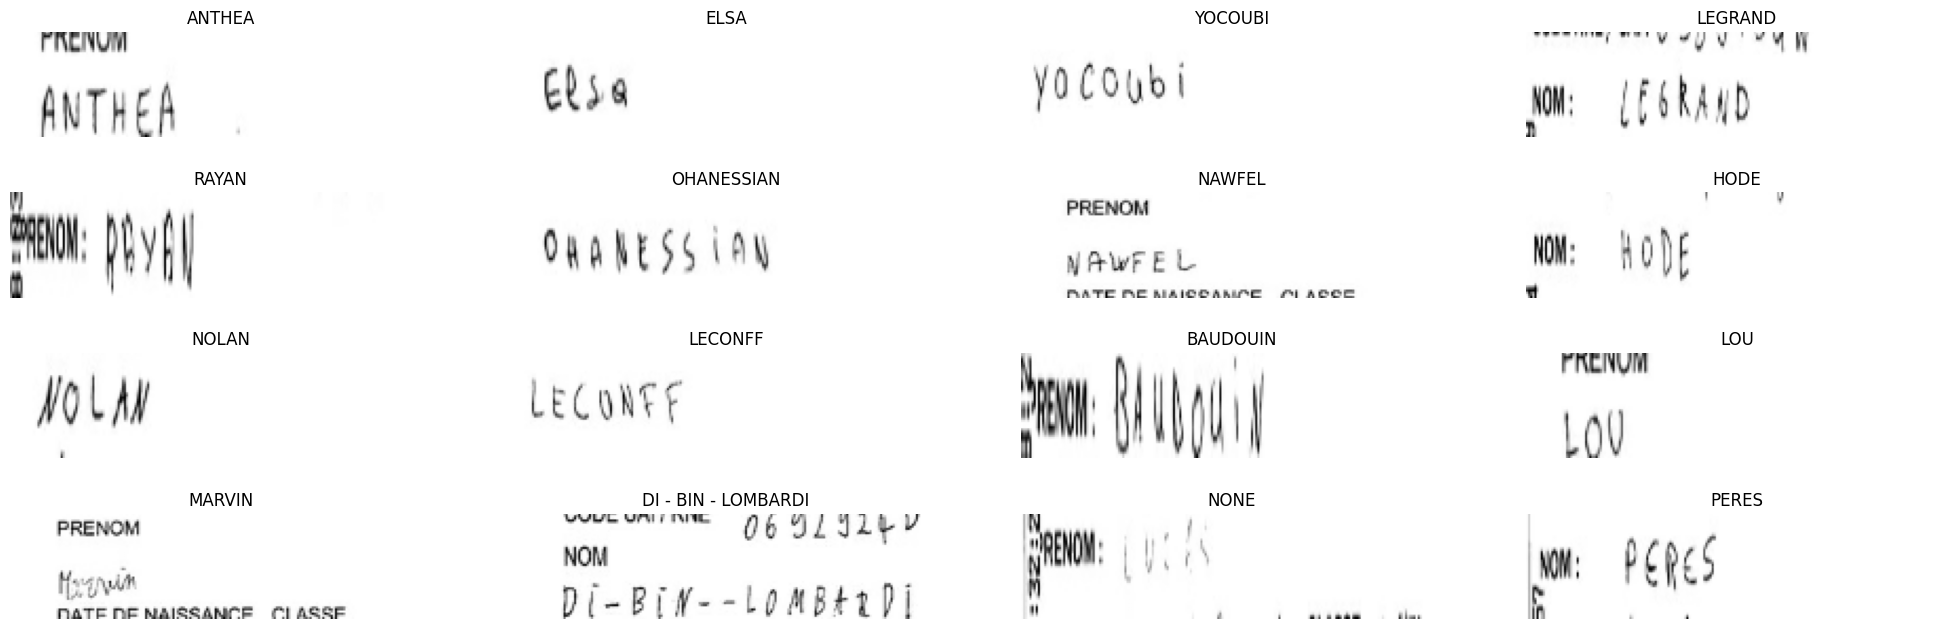

In [22]:
show_images(data=train_ds, cmap='gray')

### Criando a Classificação Temporal Conexionista (CTC)

In [23]:
class CTCLayer(layers.Layer):
  def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

        self.loss_fn = keras.backend.ctc_batch_cost

  def call(self, y_true, y_pred):

        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')

        input_len = tf.cast(tf.shape(y_pred)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')

        loss = self.loss_fn(y_true, y_pred, input_len, label_len)

        self.add_loss(loss)

        return y_pred

### OCR Model

In [24]:
input_images = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name='image')
target_labels = layers.Input(shape=(None, ), name='label')

In [25]:
# CNN
x = layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(input_images)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

In [26]:
# Encoding

encoding = layers.Reshape(target_shape=((IMG_WIDTH//4), (IMG_HEIGHT//4)*64))(x)
encoding = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(encoding)
encoding = layers.Dropout(0.2)(encoding)

In [27]:
# RNN

x = layers.Bidirectional(
    layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(encoding)
x = layers.Bidirectional(
    layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

In [28]:
output = layers.Dense(len(char_to_num.get_vocabulary())+1, activation='softmax')(x)
ctc_layer = CTCLayer()(target_labels, output)

# Model
ocr_model = keras.Model(
    inputs=[input_images, target_labels],
    outputs=[ctc_layer]
)

In [29]:
ocr_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 200, 50, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 200, 50, 32)    │            320 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 100, 25, 32)    │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 100, 25, 64)    │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 50, 12, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 50, 768)        │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 50, 64)         │         49,216 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 50, 64)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 50, 256)        │        197,632 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 50, 128)        │        164,352 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 50, 43)         │          5,547 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc_layer (CTCLayer)      │ (None, 50, 43)         │              0 │ label[0][0],           │
│                           │                        │                │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 435,563 (1.66 MB)

 Trainable params: 435,563 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
!pip install pydot

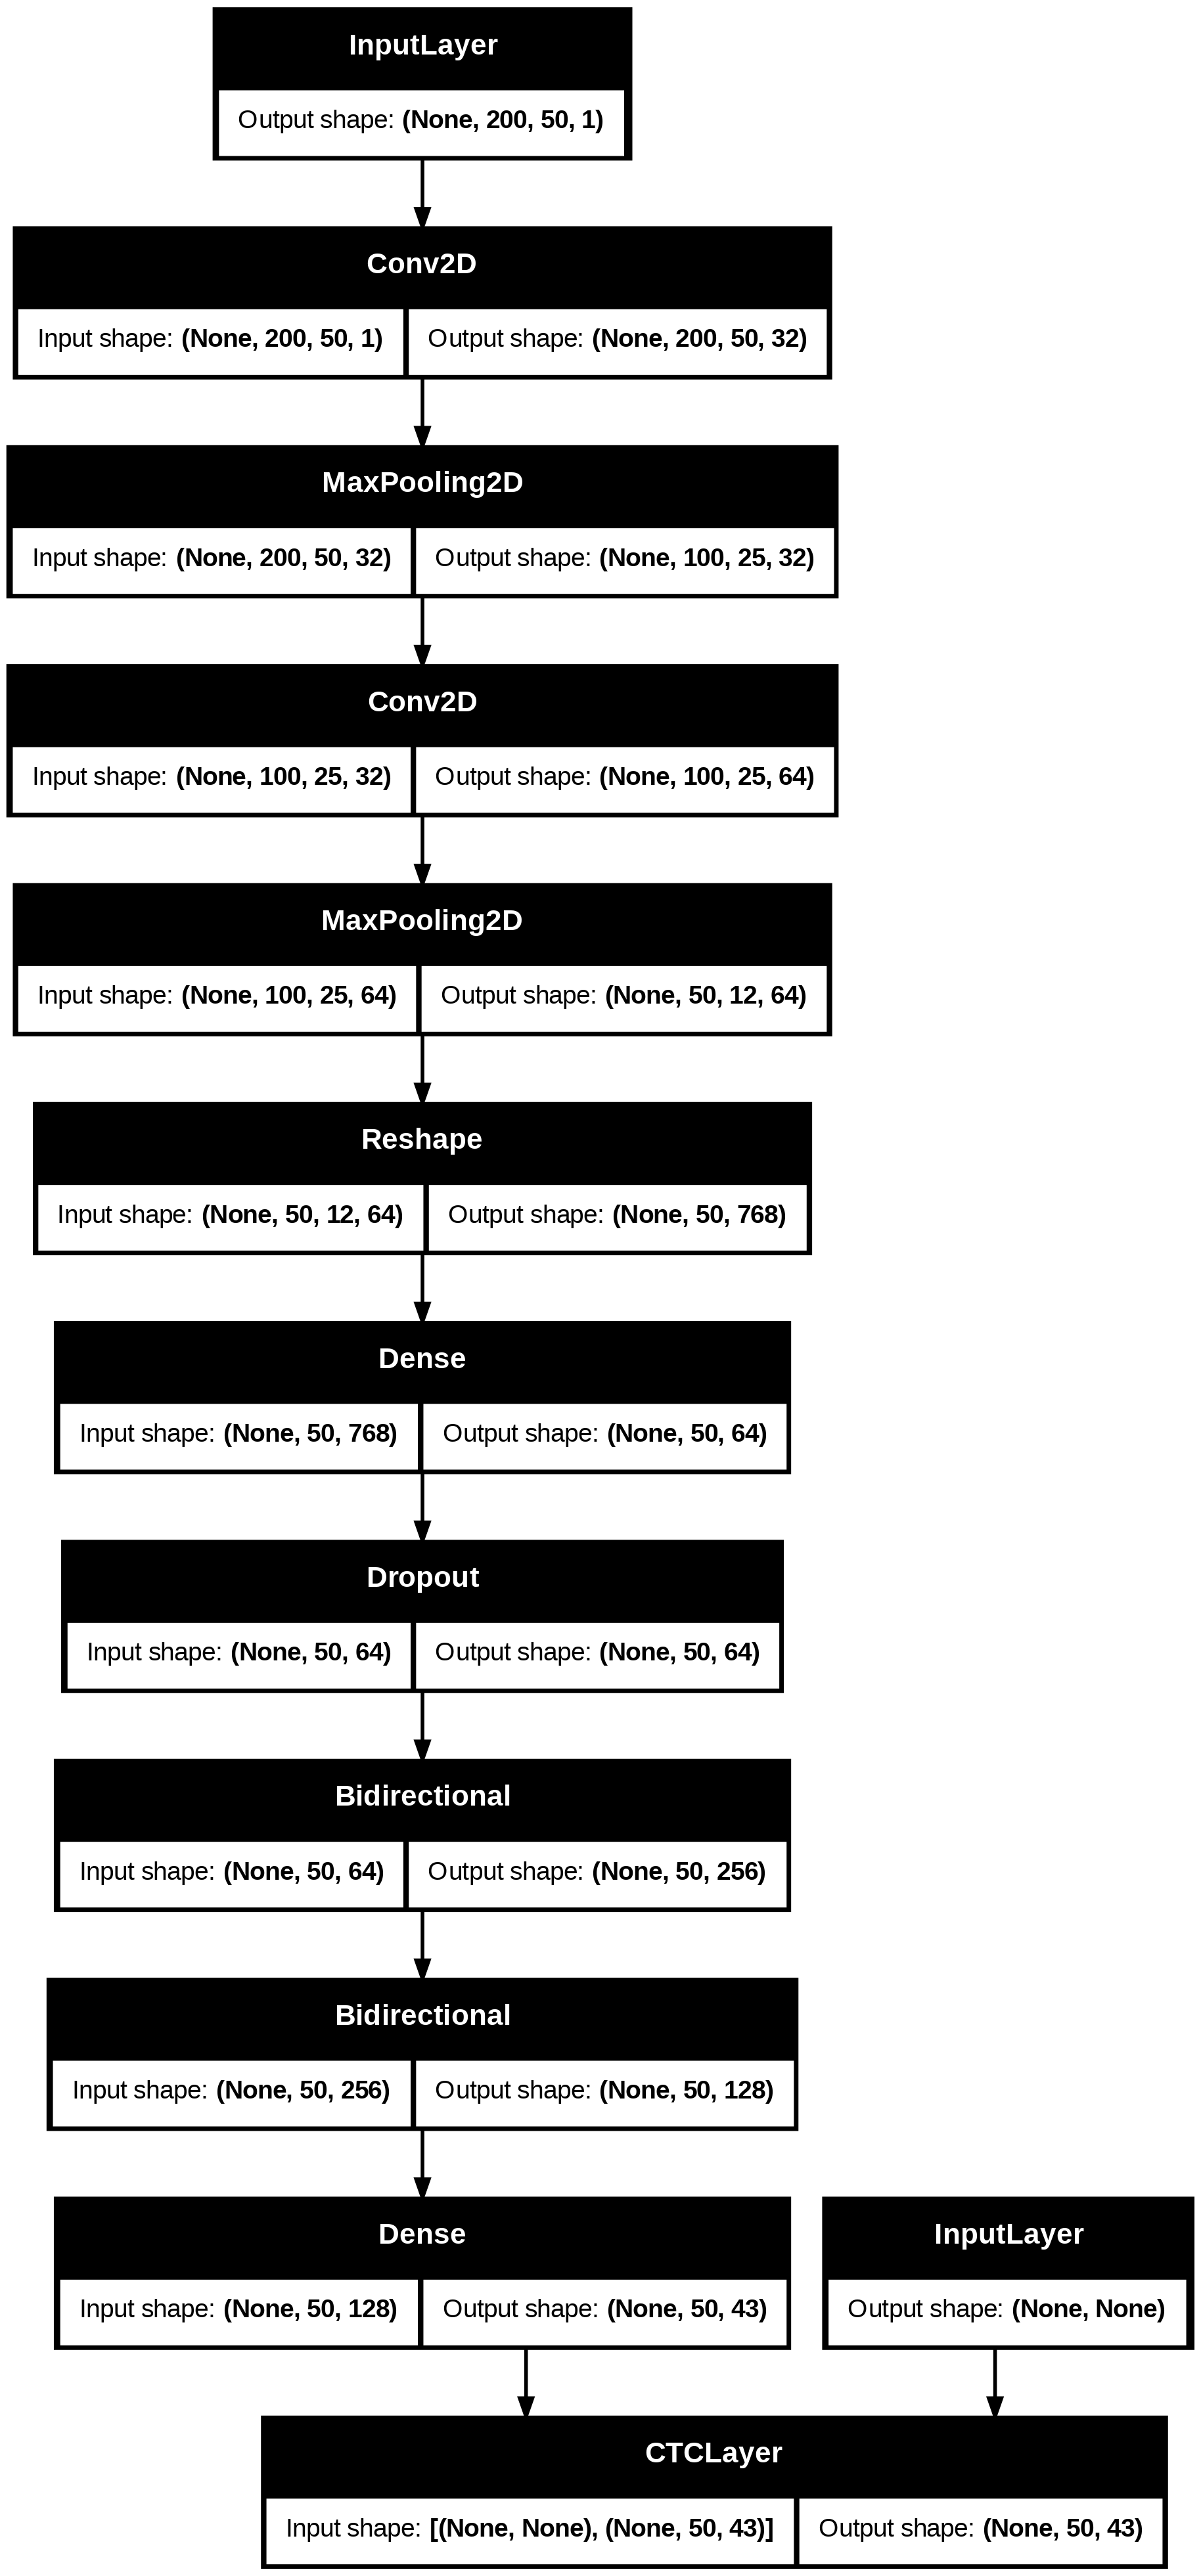

In [31]:
tf.keras.utils.plot_model(ocr_model, show_shapes=True)

### Treinamento

In [32]:
ocr_model.compile(optimizer='adam')

history = ocr_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    callbacks=CALLBACKS
)

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 384.0532

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 63s 46ms/step - loss: 384.0045 - val_loss: 315.1766
Epoch 2/50
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 311.0761

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - loss: 311.0674 - val_loss: 301.7031
Epoch 3/50
 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 300.8174

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 89s 51ms/step - loss: 300.8112 - val_loss: 296.6280
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 296.2663

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - loss: 296.2648 - val_loss: 294.7666
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 295.0977

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 41ms/step - loss: 295.0949 - val_loss: 292.1585
Epoch 6/50
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 290.9627

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 40ms/step - loss: 290.9581 - val_loss: 285.5600
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 280.9579

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - loss: 280.9505 - val_loss: 262.3460
Epoch 8/50
 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 259.3708

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - loss: 259.3538 - val_loss: 245.8445
Epoch 9/50
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 241.1124

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - loss: 241.1002 - val_loss: 222.2356
Epoch 10/50
 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 218.5380

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 92s 51ms/step - loss: 218.5176 - val_loss: 200.7077
Epoch 11/50
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 195.5760

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - loss: 195.5654 - val_loss: 176.5977
Epoch 12/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 175.8419

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 41ms/step - loss: 175.8376 - val_loss: 162.5775
Epoch 13/50
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 161.2009

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - loss: 161.1935 - val_loss: 149.9938
Epoch 14/50
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 148.7258

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 92s 51ms/step - loss: 148.7207 - val_loss: 144.0768
Epoch 15/50
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 139.2500

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 72s 41ms/step - loss: 139.2439 - val_loss: 132.2809
Epoch 16/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 128.7063

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 40ms/step - loss: 128.7027 - val_loss: 120.1431
Epoch 17/50
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 117.8203

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - loss: 117.8140 - val_loss: 113.6598
Epoch 18/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 108.0577

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - loss: 108.0555 - val_loss: 105.2343
Epoch 19/50
 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 100.2605

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - loss: 100.2555 - val_loss: 99.5935
Epoch 20/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 94.9845

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - loss: 94.9825 - val_loss: 96.7649
Epoch 21/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 90.2410

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 92s 51ms/step - loss: 90.2391 - val_loss: 93.1130
Epoch 22/50
 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 85.5701

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 72s 41ms/step - loss: 85.5653 - val_loss: 89.6891
Epoch 23/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 81.5809

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - loss: 81.5802 - val_loss: 88.2058
Epoch 24/50
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 78.4748

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 42ms/step - loss: 78.4723 - val_loss: 82.8591
Epoch 25/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 75.3891

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - loss: 75.3874 - val_loss: 80.3520
Epoch 26/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 72.6252

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 83s 42ms/step - loss: 72.6237 - val_loss: 78.0889
Epoch 27/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 69.0601

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 52s 52ms/step - loss: 69.0588 - val_loss: 75.6688
Epoch 28/50
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 65.9984

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - loss: 65.9971 - val_loss: 74.1173
Epoch 29/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 71s 41ms/step - loss: 63.3622 - val_loss: 74.8394
Epoch 30/50
 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 61.4836

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - loss: 61.4838 - val_loss: 71.0741
Epoch 31/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 59.8838

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - loss: 59.8826 - val_loss: 70.5681
Epoch 32/50
 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 58.0539

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 83s 42ms/step - loss: 58.0512 - val_loss: 68.1955
Epoch 33/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 92s 52ms/step - loss: 56.3489 - val_loss: 68.8036
Epoch 34/50
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 54.3825

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 71s 41ms/step - loss: 54.3812 - val_loss: 66.3658
Epoch 35/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - loss: 52.4983 - val_loss: 66.7659
Epoch 36/50
 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 52.4013

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 93s 53ms/step - loss: 52.3981 - val_loss: 65.0830
Epoch 37/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - loss: 50.0078 - val_loss: 66.8711
Epoch 38/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 49.8614

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - loss: 49.8605 - val_loss: 63.0057
Epoch 39/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 42ms/step - loss: 47.6413 - val_loss: 63.5951
Epoch 40/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 46.4395

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 84s 43ms/step - loss: 46.4391 - val_loss: 62.5147
Epoch 41/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - loss: 46.2980 - val_loss: 65.2383
Epoch 42/50
 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 45.6642

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - loss: 45.6621 - val_loss: 60.7175
Epoch 43/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 42ms/step - loss: 44.8762 - val_loss: 61.9592
Epoch 44/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 93s 53ms/step - loss: 42.7233 - val_loss: 67.4683
Epoch 45/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - loss: 43.7518 - val_loss: 61.2744
Epoch 46/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - loss: 41.6968 - val_loss: 62.0172
Epoch 47/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 41.0167

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 42ms/step - loss: 41.0164 - val_loss: 60.3571
Epoch 48/50
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 40.2744

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - loss: 40.2738 - val_loss: 59.4458
Epoch 49/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 42ms/step - loss: 39.7331 - val_loss: 60.2013
Epoch 50/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 92s 52ms/step - loss: 39.2427 - val_loss: 59.8791


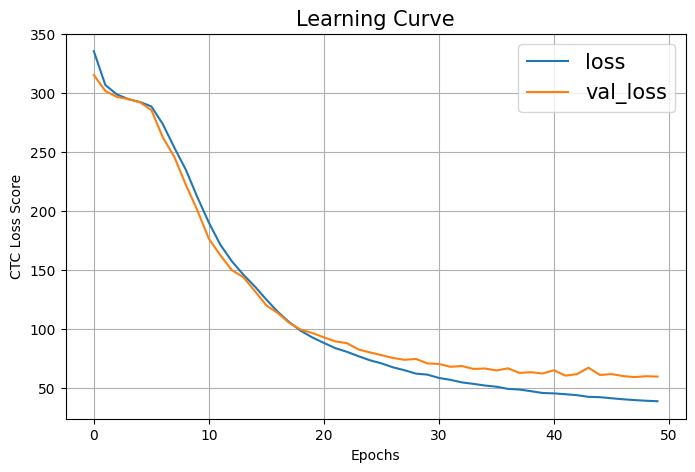

In [33]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.legend(fontsize=15)
plt.xlabel("Epochs")
plt.ylabel("CTC Loss Score")
plt.title("Learning Curve", fontsize=15)
plt.grid()
plt.savefig("OCRModel-LearningCurve.png")
plt.show()

### Previsões do modelo OCR

In [34]:
for layer in ocr_model.layers:
    print(layer.name)

image
conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
reshape
dense
dropout
bidirectional
bidirectional_1
label
dense_1
ctc_layer


In [35]:
inference_model_1 = keras.Model(
    inputs=ocr_model.input,
    outputs=ocr_model.get_layer(name='dense_1').output
)

inference_model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 200, 50, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 200, 50, 32)    │            320 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 100, 25, 32)    │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 100, 25, 64)    │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 50, 12, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 50, 768)        │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 50, 64)         │         49,216 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 50, 64)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 50, 256)        │        197,632 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 50, 128)        │        164,352 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 50, 43)         │          5,547 │ bidirectional_1[0][0]  │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 435,563 (1.66 MB)

 Trainable params: 435,563 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
inference_model_2 = keras.Model(inputs=input_images, outputs=output)

inference_model_2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)                   │ (None, 200, 50, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 200, 50, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 25, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 25, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 50, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 50, 768)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50, 64)              │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 256)             │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 50, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50, 43)              │           5,547 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 435,563 (1.66 MB)

 Trainable params: 435,563 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
def decode_pred(pred_label):
    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]
    decode = keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)[0][0][:,:MAX_LABEL_LENGTH]
    chars = num_to_char(decode)
    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]
    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]

    return filtered_texts

In [38]:
print(decode_pred(inference_model_1.predict(test_ds)))

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
['KEVIN', 'LEE', 'LENA', 'JULES', 'CHERPIN', 'MARTIN', 'VALENTINE', 'LORAS', 'THIBAULT', 'AEADI', 'GORTCHPBOF', 'MAHENTHIRAN', 'FRANECISSSICRA', 'JEANNE', 'DEBORH', 'BROUES', 'JONE', 'CORNIL-RRERROT', 'CLEMENT', 'ELIS', 'NAHISATA FATIN', 'FOURNEL', 'DECINTOLILLESA', 'BARDOT', 'DOVAL', 'ANTONY', 'LISA', 'CELIA', 'CROUZAZ', 'HUGO', 'HUEO', 'ELOUEN', 'SCHOCHAICKER', 'MORRAU', 'STEENREASTF', 'DI FANZC', 'BUIREY', 'ROMAN', 'MILLE', 'CAROLINE', 'PAUL', 'BELHARA', 'DIBOS', 'JEAN CONE', 'DRENLY', 'CLOUVIS', 'JORIS', 'MARDINI', 'CLAIRE', 'RAFFORT', 'IEHOROTS', 'DEDUYSSCHER', 'ALEXANDRE', 'RAPHAEL', 'KAIRERDINE', 'ONUT', 'GOUKAUD', 'ROMAN', 'LEVERMANN', 'JOBIER', 'MARDY', 'ALEXANDRE', 'BOULANGER', 'MARWANE', 'PARIS', 'MELANIE', 'NOUASE', 'LEURIT', 'PARENT', 'DESCHENES', 'MAHAULT', 'DAGAS', 'OUCHAINE', 'AYOUL', 'KAREN', 'ALEXIO', 'ESZAR', 'BERUENET', 'KEVIN', 'CAMBRIMI', 'ALESSA', 'CHARLES', 'ELIA', 'ALEMANDRE', 'ROY--COUTELLIER', 'LEILI', 'TAUAEL', 'MADR

In [39]:
print(decode_pred(inference_model_2.predict(test_ds)))

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: image
Received: inputs=['Tensor(shape=(16, 200, 50, 1))']
  warnings.warn(msg)


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
['KEVIN', 'LEOAE', 'LENA', 'JULES', 'CHERPIN', 'MARTIN', 'VALENTINE', 'LORAS', 'THIBAULT', 'AGADI', 'GORTCHPBOFI', 'MAHENTHIRAN', 'FRANEISSSICA', 'JEANNE', 'DEBORA', 'BROUES', 'JONL', 'CORNIL-FRERROT', 'CLEMENT', 'AELIS', 'MAMISATA-EATIH', 'FOURNEL', 'DICINT-GLILLESCA', 'BARDOT', 'DAVAL', 'ANTONI', 'LISA', 'CELIA', 'CRODZAZ', 'HUEO', 'HUEO', 'ELOVEN', 'SENOEHAZCKER', 'MOARAU', 'STENRERSTF', 'DI FONS', 'BUIREY', 'ROMAN', 'MILLE', 'CAROLINE', 'PAUL', 'BELHARA', 'DIOOS', 'JEAN-OONE', 'DRERIY', 'CLOUIS', 'JORIS', 'MARDINI', 'CLAIRE', 'RAFFORT', 'ICHOROIS', 'DEDUYSSCHER', 'ALEXANDRE', 'RAPHAEL', 'KAIRERJINE', 'UAUT', 'GOUDAUD', 'ROMAN', 'LEDERMAN', 'JODIER', 'MARDY', 'ALEXANDRE', 'BOULANGER', 'MARWANE', 'PARIS', 'MELANIE', 'NOUASE', 'LEURIT', 'PARENT', 'DESCHENES', 'HAMAULT', 'DAGOAE', 'OUCHAINE', 'AUGUL', 'KAREN', 'ALEHEO', 'ESZAR', 'BEQUCHET', 'KEVIN', 'CAMBEIKI', 'ALESSI', 'CHARLES', 'ELIA', 'ALEXANDRE', 'ROY--COUTELLIER', 'LEILI', 'TAMAIL', 'MAD

In [40]:
print(inference_model_2.input)

<KerasTensor shape=(None, 200, 50, 1), dtype=float32, sparse=False, name=image>


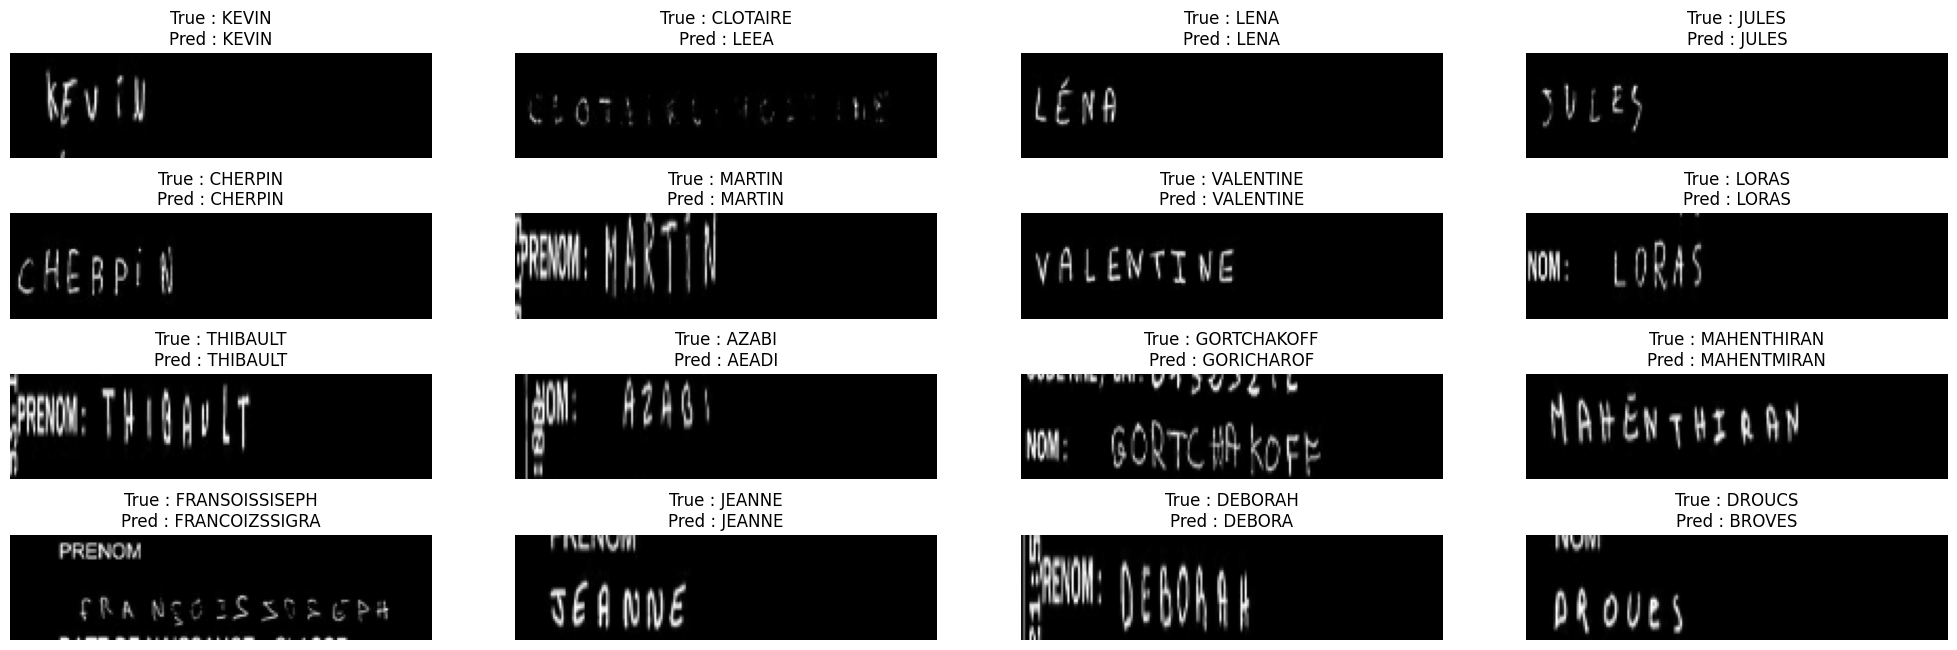

In [41]:
show_images(data=test_ds, model=inference_model_2, decode_pred=decode_pred, cmap='binary')

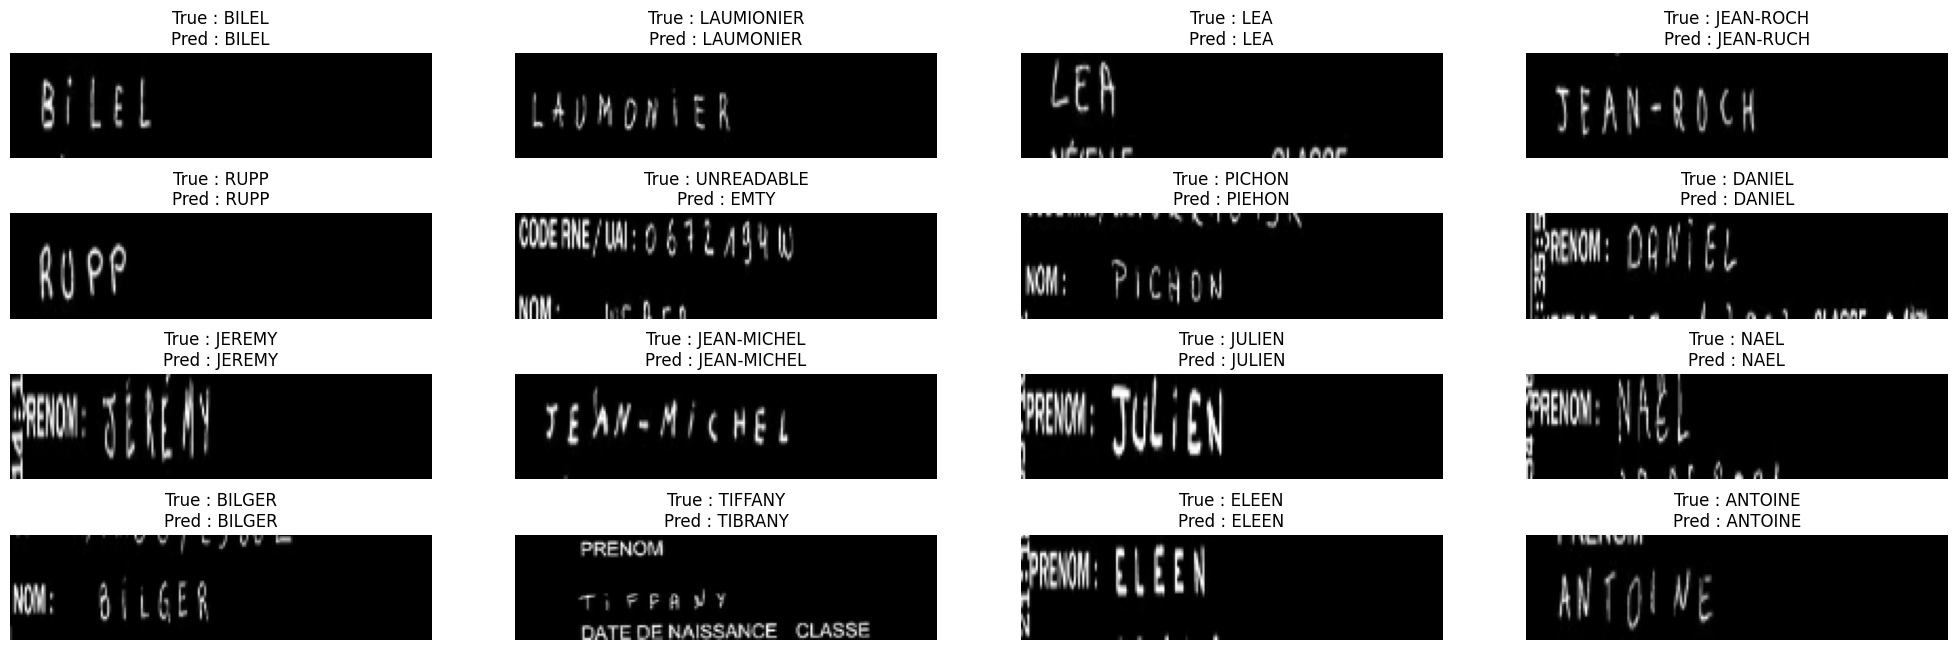

In [42]:
show_images(data=valid_ds, model=inference_model_2, decode_pred=decode_pred, cmap='binary')

### Melhorando o modelo

In [43]:
input_images = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")
target_labels = layers.Input(shape=(None, ), name="label")

x = layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(input_images)

x = layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)

x = layers.Conv2D(
    filters=128,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

encoding = layers.Reshape(target_shape=((IMG_WIDTH//4), (IMG_HEIGHT//4)*128))(x)
encoding = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(encoding)
encoding = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(encoding)
encoding = layers.Dropout(0.4)(encoding)

x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(encoding)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)

output = layers.Dense(len(char_to_num.get_vocabulary())+1, activation='softmax')(x)
ctc_layer = CTCLayer()(target_labels, output)

ocr_model_2 = keras.Model(
    inputs=[input_images, target_labels],
    outputs=[ctc_layer]
)

In [44]:
ocr_model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))

history_2 = ocr_model_2.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    callbacks=[
        callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 51ms/step - loss: 398.9592 - val_loss: 320.4686
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 60s 60ms/step - loss: 318.3856 - val_loss: 303.3896
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - loss: 302.6876 - val_loss: 297.7922
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 72s 50ms/step - loss: 296.4924 - val_loss: 293.8111
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 92s 60ms/step - loss: 293.2726 - val_loss: 292.4540
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - loss: 291.5957 - val_loss: 283.5339
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 60s 60ms/step - loss: 278.2033 - val_loss: 251.6903
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - loss: 241.9494 - val_loss: 196.4671
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - loss: 182.1816 - val_loss: 140.2257
Epoch 10/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - loss: 132.6574 - val_loss: 102.4288
Epoch 11/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 61s 60ms/step - 

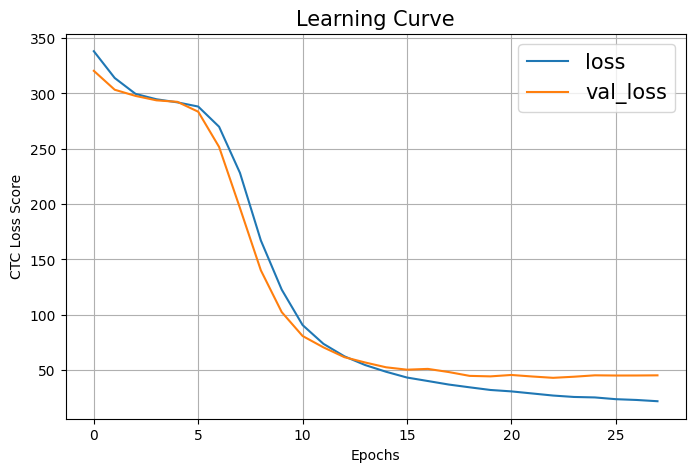

In [45]:
pd.DataFrame(history_2.history).plot(figsize=(8,5))
plt.legend(fontsize=15)
plt.xlabel("Epochs")
plt.ylabel("CTC Loss Score")
plt.title("Learning Curve", fontsize=15)
plt.grid()

plt.show()